In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import time
import json
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
import pandas as pd
import copy

% run ./result_summary.ipynb

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(plt.style.available)
plt.style.use('seaborn')
plt.style.use('seaborn-poster')
# output_path = '../output/figures'
output_path = '/Users/kobibi/WorkDocs/DeepPNML-Paper/figures'
is_plot_title = True
is_save_fig = False

['_classic_test', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10']


# PNML Vs. ERM Performence
PNML is as training is as following:
1. Train base model with all trainset
2. Freeze first layers (only enable updates of layer 5,6 in resnet20)
3. For each test sample:
    1. For each label:
        1. Add the test sample with the label to trainset
        2. Train for 10 epochs the model
        3. Keep probability of the test sample label which it was trained with
    2. Take all save probabilities and normalize them.
    3. Report the new probability assignment

In [4]:
# Print acc and mean loss
tic = time.time()
result_df, statistics_df = load_results_to_df(files_nml_2_layers)
print('result_df: loaded in {0:.2f} [s]'.format(time.time() - tic))
print(statistics_df.transpose())

result_df: loaded in 2.61 [s]
          acc  mean loss  std loss  mean entropy
nml    0.9184   0.167210  0.313679      0.197706
erm    0.9183   0.194359  0.821636      0.024840
genie  0.9875   0.027294  0.230810      0.024752


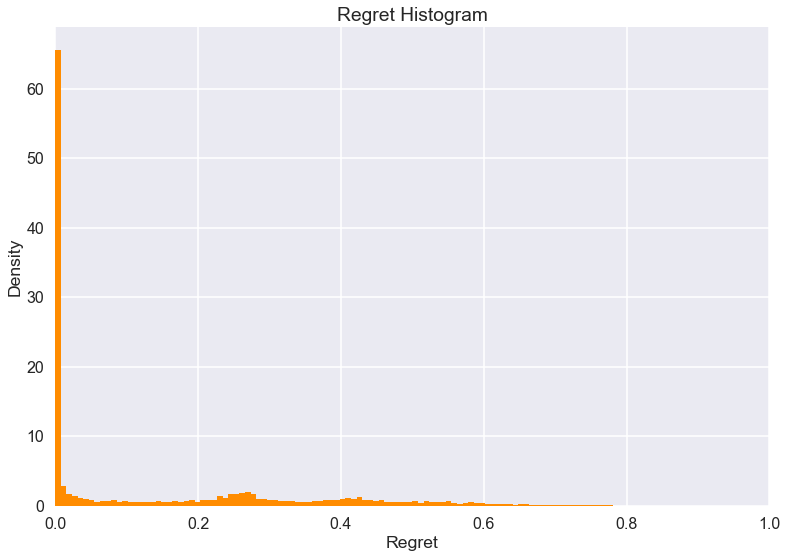

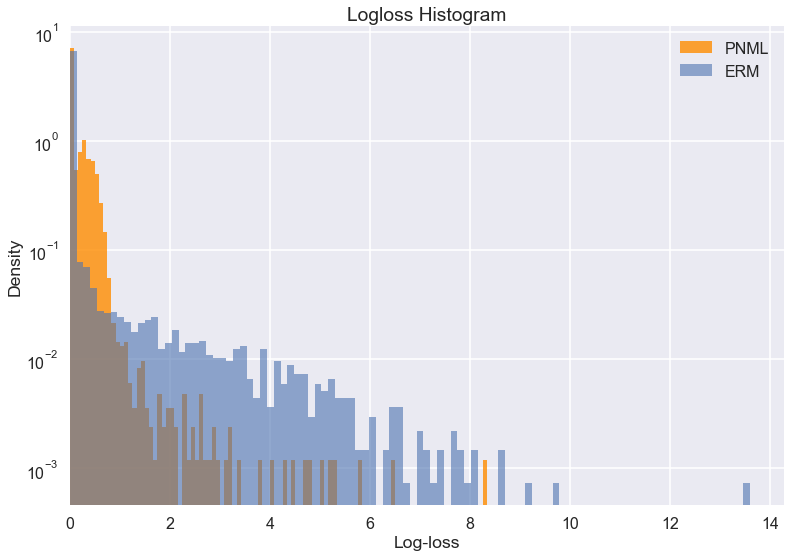

In [5]:
# Regret histogram
bins = 100
plt.hist(result_df['log10_norm_factor'], density=True,
         label='PNML', bins=bins, color='darkorange')
plt.xlim([-0.0001, 1])
plt.title('Regret Histogram') if is_plot_title else None
plt.xlabel('Regret')
plt.ylabel('Density')
plt.savefig(os.path.join(output_path, 'regret_hist.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

# logloss histogram
bins = 100
plt.hist(result_df['nml_loss'], bins=bins, alpha=0.8,
         label='PNML', density=True, color='darkorange')
plt.hist(result_df['erm_loss'], bins=bins,
         alpha=0.6, label='ERM', density=True)
plt.title('Logloss Histogram') if is_plot_title else None
plt.xlabel('Log-loss')
plt.ylabel('Density')
plt.yscale('log')
plt.xlim(left=0)
plt.legend()
plt.savefig(os.path.join(output_path, 'logloss_hist.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

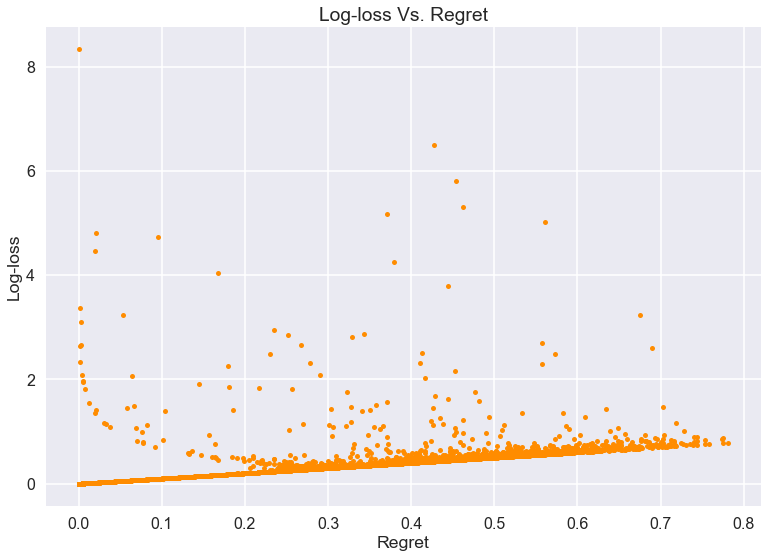

Pearson correlation:
                   log10_norm_factor  nml_loss
log10_norm_factor           1.000000  0.681776
nml_loss                    0.681776  1.000000


In [6]:
# Loss vs. NML normalization factor
plt.plot(result_df['log10_norm_factor'], result_df['nml_loss'],
         linestyle='None', color='darkorange', marker='o', label='PNML', markersize=5)
plt.title('Log-loss Vs. Regret') if is_plot_title else None
plt.xlabel('Regret')
plt.ylabel('Log-loss')
plt.savefig(os.path.join(output_path, 'loss_vs_regret.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

# Calc pearson correlation
print('Pearson correlation:')
print(result_df[['log10_norm_factor', 'nml_loss']].corr())

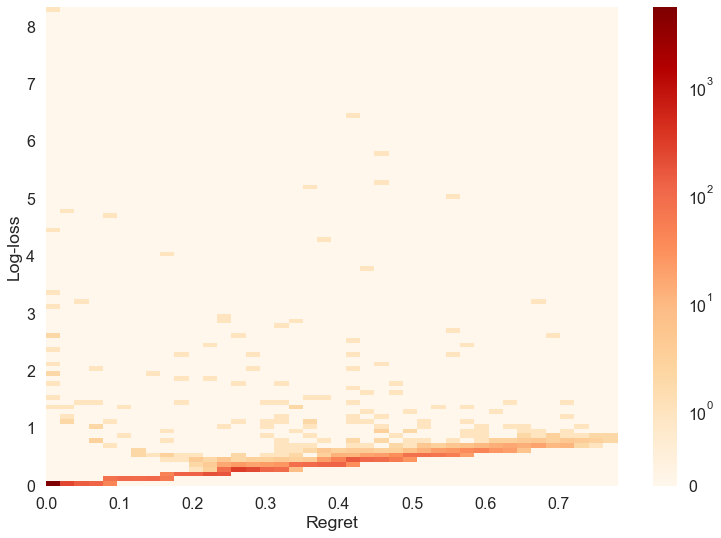

In [7]:
plt.hist2d(result_df['log10_norm_factor'], result_df['nml_loss'], 
           bins=[40,100], norm= mpl.colors.SymLogNorm(1), cmin=0, cmap=plt.cm.OrRd)
plt.xlabel('Regret')
plt.ylabel('Log-loss')
plt.colorbar()
plt.savefig(os.path.join(output_path, 'loss_vs_regret_hist2d.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


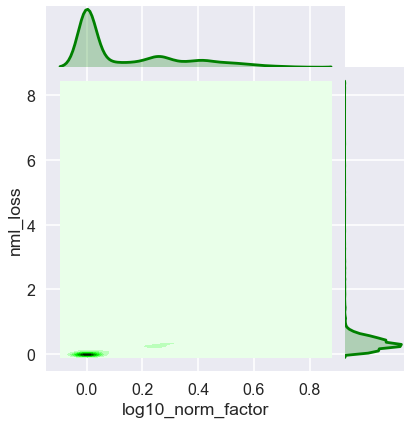

In [58]:
import seaborn as sns
mybins=np.logspace(0,np.log10(10000),100)
sns.jointplot("log10_norm_factor" , "nml_loss",  data=result_df,  
              kind="kde", space=0, color="g")#,marginal_kws={'hist_kws': {'log': True}})

# ax.set_xscale('log')
# ax.set_yscale('log')
# g.ax_marg_x.set_xscale('log')
# g.ax_marg_y.set_yscale('log')

/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 23.799999999999955, 'Regret')

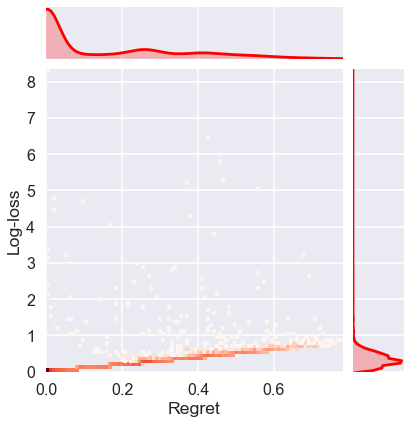

In [118]:
import matplotlib.colors as colors
# g = sns.jointplot(result_df.log10_norm_factor , result_df.nml_loss, kind="kde",
#                   space=0.2,cbar=True,
#                   n_levels=10,cbar_kws={"label": 'My colorbar', 
#                                         "norm": colors.SymLogNorm(linthresh=1, 
#                                                                   vmin=0.0, vmax=1000)})

g = sns.JointGrid(x="log10_norm_factor", y="nml_loss", data=result_df)
g.plot_marginals(sns.kdeplot, shade=True, color='red')
g.plot_joint(plt.hist2d, bins=[100,100], norm= mpl.colors.SymLogNorm(0.1), cmin=1, cmap=plt.cm.Reds)
g.ax_joint.grid(True)
g.ax_joint.set_ylabel('Log-loss')
g.ax_joint.set_xlabel('Regret')


(10, 10)
(40,)
(100,)
(40, 100)
(40, 100)
(40, 100)


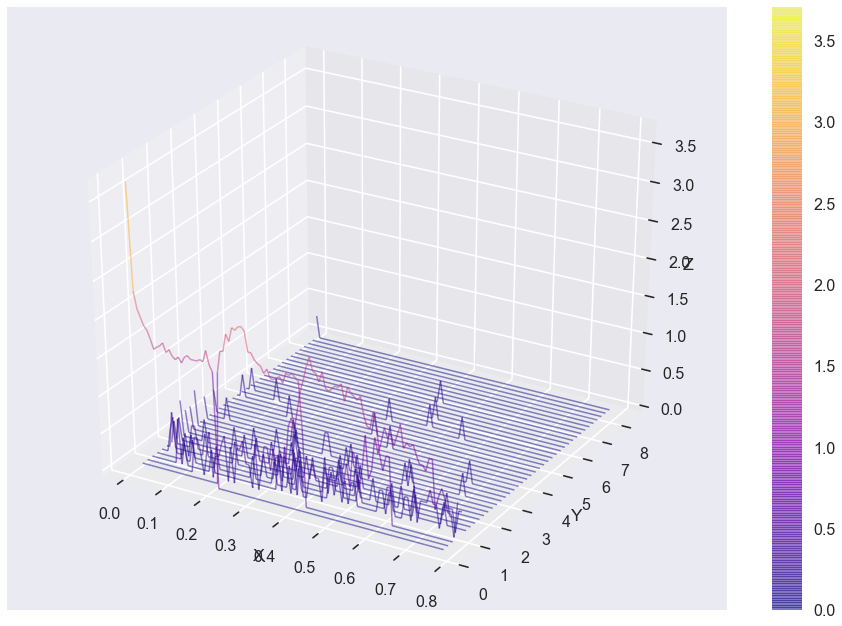

In [45]:
def waterfall_plot(fig,ax,X,Y,Z,**kwargs):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        lc = LineCollection(segments, cmap='plasma', norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    fig.colorbar(lc) # add colorbar, as the normalization is the same for all
    # it doesent matter which of the lc objects we use
    ax.auto_scale_xyz(X,Y,Z) # set axis limits

import numpy as np; import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

z, x, y =np.histogram2d(result_df['nml_loss'], result_df['log10_norm_factor'],
                       bins=[40,100])
x = x[1:]
y = y[1:]
Z = np.log10(z+1)
print(hist.shape)
print(x.shape)
print(y.shape)
# Generate data
# x = np.linspace(-2,2, 500)
# y = np.linspace(-2,2, 60)
X,Y = np.meshgrid(y,x)
# Z = np.sin(X**2+Y**2)-.2*X
# Generate waterfall plot
print(X.shape)
print(Y.shape)
print(Z.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,X,Y,Z,linewidth=1.5,alpha=0.5) 
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z') 
fig.tight_layout()

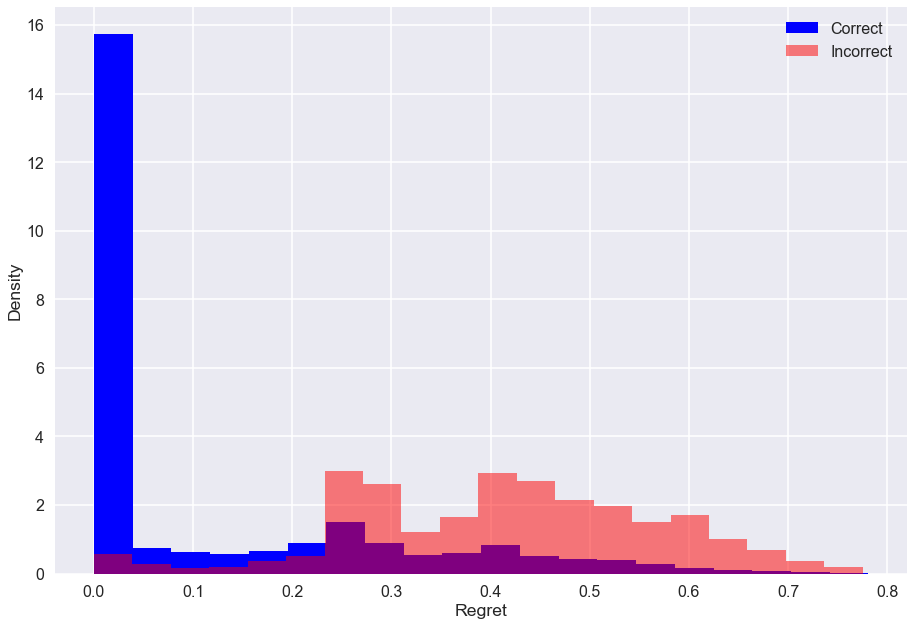


Correct = 9184, Incorrect = 816 
Mean [correct, incorrect]=[0.1156757391744595, 0.41274406045452866]


In [7]:
# Plot histogram of correct vs incorrect
correct_norm_factor = result_df['log10_norm_factor'][result_df['nml_is_correct'] == True]
incorrect_norm_factor = result_df['log10_norm_factor'][result_df['nml_is_correct'] == False]

bins = 20

plt.hist(correct_norm_factor, alpha=1, bins=bins,
         density=True, color='blue', label='Correct')
plt.hist(incorrect_norm_factor, alpha=0.5, bins=bins,
         density=True, color='red', label='Incorrect')
plt.title(
    'Regret Histogram with Correct and Incorrect Separation') if is_plot_title else None
plt.xlabel('Regret')
plt.ylabel('Density')
plt.legend()
plt.savefig(os.path.join(output_path, 'correct_incorrect_hist.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

print()
print('Correct = %d, Incorrect = %d ' %
      (correct_norm_factor.shape[0], incorrect_norm_factor.shape[0]))
print('Mean [correct, incorrect]={}'.format(
    [correct_norm_factor.mean(), incorrect_norm_factor.mean()]))

# Compose Regret based Estimator

In [8]:
#  Construct best loss based on normalization factor
threshold_list = np.linspace(np.finfo(float).eps, 1, 99)
acc_list = []
cdf_list = []
nml_thresh_loss_list = []
for threshold in threshold_list:
    df = result_df[result_df['log10_norm_factor'] < threshold]

    # loss
    nml_thresh_loss_list.append(df['nml_loss'].mean())

    # Acc
    acc_single = np.sum(df['nml_is_correct'] == True) / \
        (df.shape[0] + np.finfo(float).eps)
    acc_list.append(acc_single)

    cdf_single = df.shape[0] / result_df.shape[0]
    cdf_list.append(cdf_single)

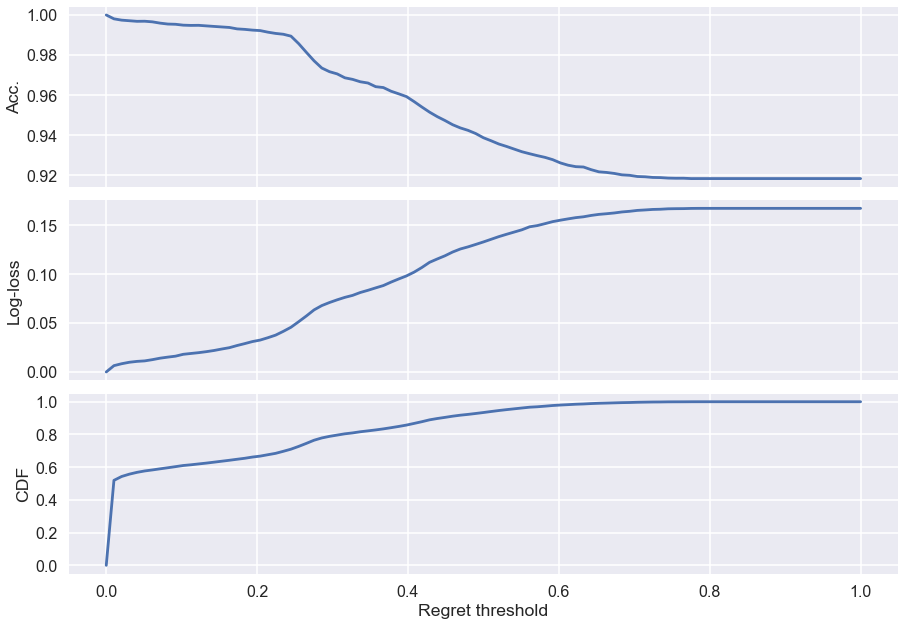

In [9]:
gs = gridspec.GridSpec(3, 1)
# Acc
acc_color = 'royalblue'
ax1 = plt.subplot(gs[0])
ax1.plot(threshold_list, acc_list)
ax1.set_ylabel('Acc.')

labels = [item.get_text() for item in ax1.get_xticklabels()]
empty_string_labels = [''] * len(labels)
ax1.set_xticklabels(empty_string_labels)

# Loss
loss_color = 'green'
ax2 = plt.subplot(gs[1])
ax2.plot(threshold_list, nml_thresh_loss_list)
ax2.set_ylabel('Log-loss')
labels = [item.get_text() for item in ax2.get_xticklabels()]
empty_string_labels = [''] * len(labels)
ax2.set_xticklabels(empty_string_labels)

# CDF
ax3 = plt.subplot(gs[2])
ax3.plot(threshold_list, cdf_list)
ax3.set_yticks(np.linspace(0, 1, 6))
ax3.set_xlabel('Regret threshold')
ax3.set_ylabel('CDF')

# Save and show
plt.savefig(os.path.join(output_path, 'regret_based_calss_all.jpg'),
            dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

# Top K accuracy

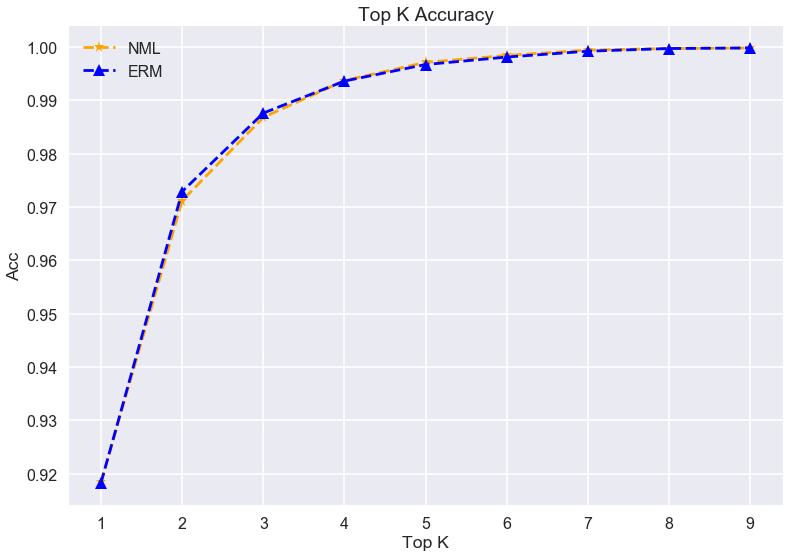

In [10]:
results_dict = load_dict_from_file_list(files_nml_2_layers)

acc_top_k_nml_list, acc_top_k_erm_list = [], []
for k in range(1, 10):
    acc_top_k_nml, acc_top_k_erm = calculate_top_k_acc(results_dict, k)
    acc_top_k_nml_list.append(acc_top_k_nml)
    acc_top_k_erm_list.append(acc_top_k_erm)

plt.plot(list(range(1, 10)), acc_top_k_nml_list,
         '--*', label='NML', color='orange')
plt.plot(list(range(1, 10)), acc_top_k_erm_list,
         '--^', label='ERM', color='blue')
plt.xlabel('Top K')
plt.ylabel('Acc')
plt.title('Top K Accuracy')
plt.legend()
plt.show()

## Constraint min prob

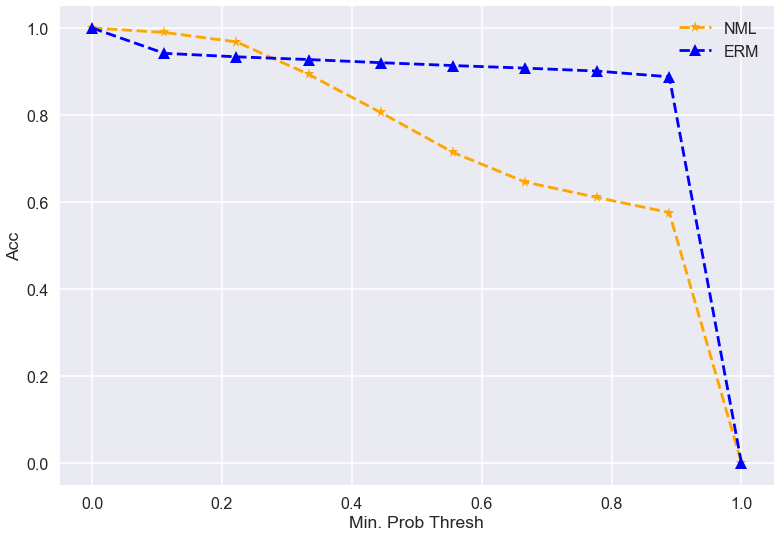

In [11]:
# Constraint predicted probability to be larger than prob_thresh
results_dict = load_dict_from_file_list(files_nml_2_layers)
acc_top_k_nml_list, acc_top_k_erm_list = [], []
prob_thresh_list = np.linspace(0, 1, 10)
for prob_thresh in prob_thresh_list:
    acc_top_k_nml, acc_top_k_erm = calculate_top_k_acc(
        results_dict, 10, prob_thresh)
    acc_top_k_nml_list.append(acc_top_k_nml)
    acc_top_k_erm_list.append(acc_top_k_erm)

plt.plot(prob_thresh_list, acc_top_k_nml_list,
         '--*', label='NML', color='orange')
plt.plot(prob_thresh_list, acc_top_k_erm_list,
         '--^', label='ERM', color='blue')
plt.xlabel('Min. Prob Thresh')
plt.ylabel('Acc')
plt.title(
    'True label probability higher then Min. Prob Thresh') if is_plot_title else plt
plt.legend()
plt.show()

# Out  of Disterbution

In [12]:
# Load svhn and noise
results_df_cifar10, statistic_cifar10 = load_results_to_df(files_nml_2_layers)
print('Cifar10: loaded %d keys' % results_df_cifar10.shape[0])
results_df_noise, statistic_noise = load_results_to_df(
    files_noise, is_out_of_dist=True)
print('Noise: loaded %d keys' % results_df_noise.shape[0])
results_df_svhn, statistic_svhn = load_results_to_df(
    files_svhn, is_out_of_dist=True)
print('SVHN: loaded %d keys' % results_df_svhn.shape[0])

Cifar10: loaded 10000 keys
Noise: loaded 100 keys
SVHN: loaded 100 keys


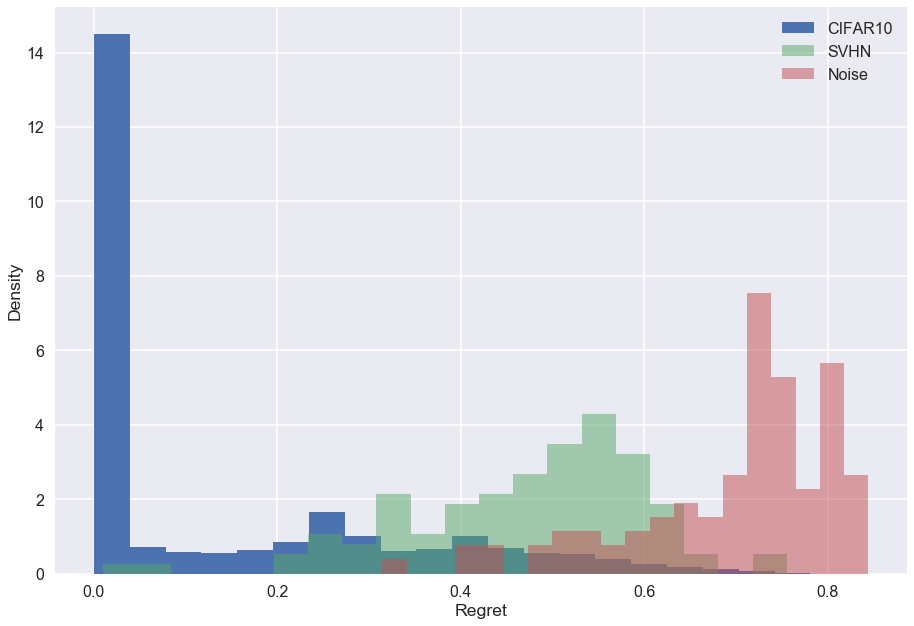

Mean: cifar, svhn, noise: [0.13991651419091314, 0.47305804001135926, 0.6994421087314094]


In [13]:
# Plot
bins = 20
plt.hist(results_df_cifar10['log10_norm_factor'], alpha=1, density=True, label='CIFAR10', bins=bins)
plt.hist(results_df_svhn['log10_norm_factor'], alpha=0.5, density=True, label='SVHN', bins=bins)
plt.hist(results_df_noise['log10_norm_factor'], alpha=0.5, density=True, label='Noise', bins=bins)
plt.ylabel('Density')
plt.xlabel('Regret')
plt.title('Out Of Distribution Regret Histogram') if is_plot_title else None
plt.legend()
plt.savefig(os.path.join(output_path, 'out_of_dist_hist.jpg'),
            dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()
print('Mean: cifar, svhn, noise: {}'.format([results_df_cifar10['log10_norm_factor'].mean(),
                                             results_df_svhn['log10_norm_factor'].mean(),
                                             results_df_noise['log10_norm_factor'].mean()]))


## Entropy 

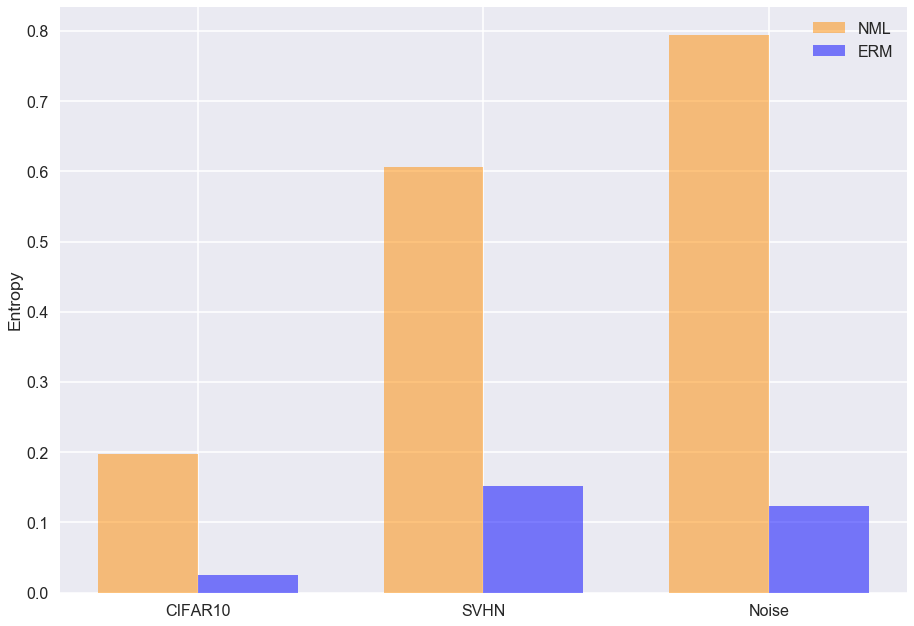


SVHN:
                   nml       erm
acc           0.080000  0.070000
mean loss          NaN       NaN
std loss           NaN       NaN
mean entropy  0.606728  0.151538

Noise:
                   nml       erm
acc           0.000000  0.000000
mean loss          NaN       NaN
std loss           NaN       NaN
mean entropy  0.794805  0.123688


In [14]:
# Plot entropy
objects = ('CIFAR10', 'SVHN', 'Noise')
y_pos = np.arange(len(objects))
bar_width = 0.35
opacity = 0.8

plt.bar(y_pos - bar_width / 2, [statistic_cifar10.loc['mean entropy']['nml'],
                                statistic_svhn.loc['mean entropy']['nml'],
                                statistic_noise.loc['mean entropy']['nml']],
        bar_width, alpha=0.5, color='darkorange', label='NML')

plt.bar(y_pos + bar_width / 2, [statistic_cifar10.loc['mean entropy']['erm'],
                                statistic_svhn.loc['mean entropy']['erm'],
                                statistic_noise.loc['mean entropy']['erm']],
        bar_width, alpha=0.5, color='blue', label='ERM')

plt.xticks(y_pos, objects)
plt.ylabel('Entropy')
plt.title('Entropy of out of distribution sampels') if is_plot_title else None
plt.legend()
plt.savefig(os.path.join(output_path, 'out_of_dist_entropy.jpg'),
            dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

print()
print('SVHN:')
print(statistic_svhn)

print()
print('Noise:')
print(statistic_noise)


##  Evaluation Metrices

In [15]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from scipy.ndimage.filters import gaussian_filter
import math
from scipy.stats import ks_2samp


def bhattacharyya(a, b):
    return -np.log(np.sum(np.sqrt(a * b)))


def kl(p, q):
    p = np.asarray(p, dtype=np.float)
    p[p == 0] = np.finfo(float).eps

    q = np.asarray(q, dtype=np.float)
    q[q == 0] = np.finfo(float).eps
    return np.sum(np.where(p > np.finfo(float).eps, - p * np.log(q / p), 0))


def kl_distance(a, b):
    return 0.5*(kl(a, b) + kl(b, a))


def histogram_and_smooth(data, nbins=10, sigma=1):
    hist = np.histogram(data, bins=nbins)[0]
    hist_smooth = gaussian_filter(hist, sigma)
    hist_smooth_normalized = hist_smooth/np.sum(hist_smooth)
    return hist_smooth_normalized


def calc_p_lamb(a_distribution, b_distribution, lamb):
    """
    Calc P_lamb distribution: P_lambda = a^lamb * b^(1-lamb) / Normalize
    """
    p_lamb = np.power(a_distribution, lamb) * np.power(b_distribution, 1-lamb)
    p_lamb /= np.sum(p_lamb)
    return p_lamb


def find_lamb_star(a_distribution, b_distribution):
    """
    Find lambda^* for which D(a||P_lambda) = D(b||P_lambda) 
    """
    distance = []
    lamb_list = np.flip(np.linspace(0, 1, 20))

    # For each lambda calculate the Distance D(a||P_lambda) - D(b||P_lambda)
    for lamb in lamb_list:
        p_lamb = calc_p_lamb(a_distribution, b_distribution, lamb)
        distance.append(kl(p_lamb, a_distribution) -
                        kl(p_lamb, b_distribution))

    # Find lambda for which the the distance is zero
    lamb_star = np.interp(0.0, distance, lamb_list)

    # Get the KL value in that lamb_star: D(a||P_lambda)
    p_lamb_star = calc_p_lamb(a_distribution, b_distribution, lamb_star)
    return kl(p_lamb_star, in_hist)


def calc_performance_in_out_dist(true_ind, score_ind):
    """
    Calculate evaluation matrics
    """
    score_ood = 1 - np.array(score_ind)
    true_ood = 1 - np.array(true_ind)

    true_len = np.sum(true_ind)
    false_len = len(true_ind) - true_len
    sample_weight = [1] * true_len + [true_len / false_len] * false_len

    # AUROC
    res_auc = roc_auc_score(true_ood, score_ood, sample_weight=sample_weight)

    # AUPR-Out
    ap_out = average_precision_score(
        true_ood, score_ood, sample_weight=sample_weight)

    # AUPR-In
    ap_in = average_precision_score(
        true_ind, score_ind, sample_weight=sample_weight)

    # KL distance
    score_ind = np.array(score_ind)
    true_ind = np.array(true_ind)
    in_hist = histogram_and_smooth(
        score_ind[true_ind == True], nbins=20, sigma=0)
    out_hist = histogram_and_smooth(
        score_ind[true_ind == False], nbins=20, sigma=0)
    kl_dist = kl_distance(in_hist, out_hist)

    # Bhattacharyya distance
    bhatt_dist = bhattacharyya(in_hist, out_hist)

    # P_lambda
    kl_in_p_lambda = find_lamb_star(in_hist, out_hist)

    ood_df = pd.DataFrame({
        # 'AUROC': [res_auc], 'AP-In': [ap_in], 'AP-Out': [ap_out],
        'KL Divergence': [kl_dist], 'Bhattach Distance': [bhatt_dist],
        'KL in P_lamb': [kl_in_p_lambda]
    })

    return ood_df

In [16]:
ind_df = results_df_cifar10
for (ooo_dataset, ooo_df) in zip(['Noise', 'SVHN'], [results_df_noise, results_df_svhn]):
    upsample_ratio = int(ind_df.shape[0] / ooo_df.shape[0])
    print('Upsample ratio: ', upsample_ratio)

    # Baseline Max prob of ERM
    y_score_ind = ind_df[['erm_' + str(x) for x in range(10)]].max(axis=1).tolist() + \
        ooo_df[['erm_' + str(x) for x in range(10)]].max(axis=1).tolist()
    y_true_ind = [True] * ind_df.shape[0] + [False] * ooo_df.shape[0]
    ood_df_erm_baseline = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    ood_df_erm_baseline = ood_df_erm_baseline.rename(index={0: 'Max Prob'})

    # Regret
    y_score_ind = (1.0 - ind_df['log10_norm_factor']).tolist() + \
                  (1.0 - ooo_df['log10_norm_factor']).tolist()
    y_true_ind = [True] * ind_df.shape[0] + [False] * ooo_df.shape[0]

#     y_score_ind = (1.0 - ind_df['log10_norm_factor']).tolist() + \
#                   (1.0 - ind_df['log10_norm_factor']).tolist()
#     y_true_ind = [True] * ind_df.shape[0] + [False] * ind_df.shape[0]

    ood_df_ours = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    ood_df_ours = ood_df_ours.rename(index={0: 'Regret'})

    # Summary
    merged_pd = pd.concat([ood_df_erm_baseline, ood_df_ours])
    print('%s:' % ooo_dataset)
    print(merged_pd)
    print()

    # Histogram based on Ouf Of Dist confidence
    f, axarr = plt.subplots(2, 1)
    axarr[0].hist(ind_df[['erm_' + str(x) for x in range(10)]
                         ].max(axis=1), alpha=1.0, density=True, label='In-Dist')
    axarr[0].hist(ooo_df[['erm_' + str(x) for x in range(10)]
                         ].max(axis=1), alpha=0.5, density=True, label=ooo_dataset)
    axarr[0].set_xlabel('Max Probabiliy')

    axarr[1].hist(1.0 - ind_df['log10_norm_factor'],
                  alpha=1.0, density=True, label='In-Dist')
    axarr[1].hist(1.0 - ooo_df['log10_norm_factor'],
                  alpha=0.5, density=True, label=ooo_dataset)
    axarr[1].set_xlabel('1 - Regret')

    f.subplots_adjust(hspace=0.5)
    plt.show()

Upsample ratio:  100


NameError: name 'in_hist' is not defined

# Random labels

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import json
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
import pandas as pd
import copy

% run ./result_summary.ipynb

In [ ]:
# Count param difference between WideResnet and Resnet20
from wide_resnet import WideResNet
from resnet import resnet20

model = WideResNet()
wide_resnet_params = sum(p.numel() for p in model.parameters())
model = resnet20()
resnet20_params = sum(p.numel() for p in model.parameters())
print('[WideResnet Resnet20]=[{} {}]'.format(
    wide_resnet_params, resnet20_params))
print('Ratio {}]'.format(wide_resnet_params / resnet20_params))

In [ ]:
# Extract the log normalization factor
random_df = pd.DataFrame(columns=['nml_acc', 'erm_acc', 'genie_acc',
                                  'log10_norm_factor',
                                  'nml_mean_loss', 'erm_mean_loss', 'genie_mean_loss'])

# random_prob, files_random = random_prob_early_stop, files_random_early_stop
# random_prob, files_random = random_prob_2_layers_early_stop, files_random_2_layers_early_stop
# random_prob, files_random = random_prob_6_ep_layers_early_stop, files_random_6_ep_early_stop
random_prob, files_random = random_prob_new, files_random_new

for (rand_prob_single, file_random) in zip(random_prob, files_random):
    results_df, statistics_df = load_results_to_df(
        file_random)  # , is_random_labels=True)
    print('Random Prob = {}, num={}'.format(
        rand_prob_single, results_df.shape[0]))
    random_df.loc[rand_prob_single] = [statistics_df.loc['acc']['nml'],
                                       statistics_df.loc['acc']['erm'],
                                       statistics_df.loc['acc']['genie'],
                                       results_df['log10_norm_factor'].mean(),
                                       statistics_df.loc['mean loss']['nml'],
                                       statistics_df.loc['mean loss']['erm'],
                                       statistics_df.loc['mean loss']['genie']]
print('Random df:')
random_df.transpose().round(2)

In [ ]:
# Plot
plt.plot(random_df.index.values,
         random_df['log10_norm_factor'], '--*', label='NML')
plt.ylabel('Regret')
plt.xlabel('Prob of random')
plt.title('Regret Vs. Prob to be Random') if is_plot_title else None
plt.savefig(os.path.join(output_path, 'random_prob_regret.jpg'),
            dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

In [ ]:
# Check noisy data
plt.plot(random_df.index.values, random_df['erm_mean_loss'], label='ERM')
plt.plot(random_df.index.values, random_df['nml_mean_loss'], label='PNML')
plt.plot(random_df.index.values, random_df['genie_mean_loss'], label='Genie')
plt.title('Loss of random labels') if is_plot_title else None
plt.ylabel('Loss')
plt.xlabel('Prob to be Random')
plt.legend()
plt.savefig(os.path.join(output_path, 'random_prob_loss.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

plt.plot(random_df.index.values, random_df['erm_acc'], label='ERM')
plt.plot(random_df.index.values, random_df['nml_acc'], label='PNML')
plt.plot(random_df.index.values, random_df['genie_acc'], label='Genie')
plt.title('Acc of random labels') if is_plot_title else None
plt.ylabel('Acc')
plt.xlabel('Prob to be Random')
plt.legend()
plt.savefig(os.path.join(output_path, 'random_prob_acc.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline


def smooth_graph(x, y, pow=1):

    x_smooth = np.linspace(x.min(), x.max(), 300)
    spl = make_interp_spline(x, y, k=pow)
    y_smooth = spl(x_smooth)
    return x_smooth, y_smooth


# Check noisy data
color = 'royalblue'
fig, ax1 = plt.subplots()

x, y = smooth_graph(random_df.index.values, random_df['erm_mean_loss'])
ax1.plot(x, y, label='ERM log-loss')

x, y = smooth_graph(random_df.index.values, random_df['nml_mean_loss'])
ax1.plot(x, y, label='PNML log-loss')

ax1.set_ylabel('Loss')
ax1.set_ylabel('Log-loss')
ax1.set_xlabel('Prob to be random')

# Plot
ax2 = ax1.twinx()
x, y = smooth_graph(random_df.index.values, random_df['log10_norm_factor'])
ax2.plot(x, y, color='indianred', label='Regret')
ax2.set_ylabel('Regret')

# ax2 ticks
l = ax1.get_ylim()
l2 = ax2.get_ylim()


def f(x): return l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])


ticks = f(ax1.get_yticks())
ax2.yaxis.set_major_locator(mpl.ticker.FixedLocator(ticks))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

# Legends
ax1.legend(loc=(.04, .87), frameon=False)
ax2.legend(loc=(.04, .95), frameon=False)


plt.savefig(os.path.join(output_path, 'random_prob_regret_and_loss.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

# Twice Universality

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import json
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
import pandas as pd
import copy

% run ./result_summary.ipynb


### Cifar

In [ ]:
print('load 0 layers')
nml_0_df = result_dict_to_erm_df(load_dict_from_file_list(files_nml_2_layers))
print('load 2 layers')
nml_2_df = result_dict_to_nml_df(load_dict_from_file_list(files_nml_2_layers))
print('load 7 layers')
nml_7_df = result_dict_to_nml_df(load_dict_from_file_list(files_nml_7_layers))

# Create twice df dataframe
twice_df, idx_common = create_twice_univ_df([nml_0_df, nml_2_df, nml_7_df])
twice_statistic_df = calc_statistic_from_df_single(twice_df).rename(columns={'statistics': 'Twice Univ'})

# Print statistic of all
twice_statistic_df = calc_statistic_from_df_single(twice_df).rename(columns={'statistics': 'Twice Univ'})
nml_0_statistic_df = calc_statistic_from_df_single(nml_0_df.loc[idx_common]).rename(columns={'statistics':
                                                                                                 '0 layers'})
nml_2_statistic_df = calc_statistic_from_df_single(nml_2_df.loc[idx_common]).rename(columns={'statistics':
                                                                                                 '2 layers'})
nml_7_statistic_df = calc_statistic_from_df_single(nml_7_df.loc[idx_common]).rename(columns={'statistics':
                                                                                                 '7 layers'})
#--
print(pd.concat([twice_statistic_df,
                 nml_0_statistic_df,
                 nml_2_statistic_df,
                 nml_7_statistic_df], axis=1, join='inner').transpose())


### MNIST

In [ ]:
nml_0_df = result_dict_to_erm_df(load_dict_from_file_list(files_mnist_1_layers))
print('loaded 0 layers MNIST, {} samples'.format(nml_0_df.shape[0]))
nml_1_df = result_dict_to_nml_df(load_dict_from_file_list(files_mnist_1_layers))
print('loaded 1 layers MNIST, {} samples'.format(nml_1_df.shape[0]))
nml_2_df = result_dict_to_nml_df(load_dict_from_file_list(files_mnist_2_layers))
print('loaded 2 layers MNIST, {} samples'.format(nml_2_df.shape[0]))

# Create twice df dataframe
twice_df, idx_common = create_twice_univ_df([nml_0_df, nml_1_df, nml_2_df])
twice_statistic_df = calc_statistic_from_df_single(twice_df).rename(columns={'statistics': 'Twice Univ'})

# Print statistic of all
twice_statistic_df = calc_statistic_from_df_single(twice_df).rename(columns={'statistics': 'Twice Univ'})
nml_0_statistic_df = calc_statistic_from_df_single(nml_0_df.loc[idx_common]).rename(columns={'statistics':
                                                                                                 '0 layers'})
nml_1_statistic_df = calc_statistic_from_df_single(nml_1_df.loc[idx_common]).rename(columns={'statistics':
                                                                                                 '1 layers'})
nml_2_statistic_df = calc_statistic_from_df_single(nml_2_df.loc[idx_common]).rename(columns={'statistics':
                                                                                                 '2 layers'})
#--
print('Num of common index {}'.format(twice_df.shape[0]))
print(pd.concat([twice_statistic_df,
                 nml_0_statistic_df,
                 nml_1_statistic_df,
                 nml_2_statistic_df], axis=1, join='inner').transpose())


# Visualize False classified
Visaulaize the image of the false classified by the ERM and NML

In [ ]:
result_df.head()


In [ ]:
# Check when erm and nml are not agree
disagree = np.logical_not(
    np.logical_and(np.array(result_df['nml_is_correct']), np.array(np.array(result_df['erm_is_correct']))))
disagree_indxes = np.array(result_df.index.values)[disagree == True].astype(np.int).tolist()
print(disagree_indxes)


In [ ]:
# Given a dict an idx, visualize ERM and NMl with prob of each. along with ground truth

# Inputs
results_dict = load_dict_from_file_list(files_nml_2_layers)
dict_idxes = [158, 384, 456]  #disagree_indxes # [245, 246]

# Initialize dataset and plots
fig = plt.figure(figsize=(20, 6 * len(dict_idxes)))
trainloader, testloader, classes = create_cifar10_dataloaders('../data', 1, 1)

# Loop on dict indxes
for iter_idx, dict_idx in enumerate(dict_idxes):
    prob_nml, true_label, predicted_label, prob_erm = extract_probabilities_list(results_dict[str(dict_idx)])
    prob_nml, normalization_factor = execute_normalize_prob(prob_nml)

    # Extract class names
    class_predict_nml = classes[np.argmax(prob_nml)]
    class_predict_erm = classes[np.argmax(prob_erm)]
    class_predict_gt = classes[true_label]
    # Extract image
    data = testloader.dataset.test_data[dict_idx]

    # Plot the image
    ax = fig.add_subplot(len(dict_idxes), 1, iter_idx + 1)
    ax.imshow(data)
    ax.set_title('[NML ERM True] = Label: {} \n [NML ERM] Prob: {}'
                 .format([class_predict_nml, class_predict_erm, class_predict_gt],
                         np.round([prob_nml[np.argmax(prob_nml)], prob_erm[np.argmax(prob_erm)]], 3)))

plt.show()
